# Sentiment Analysis on IMDB Reviews using LSTM

In this work, we implement sentiment analysis model using LSTM (Long Short-Term Memory) neural networks to classify IMDB movie reviews as positive or negative. The notebook follows a standard deep learning workflow from data loading to model evaluation.


### Import necessary libraries

In [1]:
import pandas as pd # data handling
import re # for regular expressions
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt # for visualization
import seaborn as sns
import nltk # text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle # for serialization
import tensorflow as tf # for deep learning components

### NLTK Downloads
Downloads NLTK resources needed for text processing

In [2]:
nltk.download('punkt') # tokenizer
nltk.download('stopwords') # common words to remove
nltk.download('punkt_tab') # additional tokenizer data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Text Cleaning Function
Defines clean_text() function that:

> Removes HTML tags

> Removes non-alphabetic characters

> Converts to lowercase

> Tokenizes text

> Removes stopwords

> Joins filtered tokens back into string

In [3]:
# Load and clean data
def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text) # non-alphabetic characters
    text = text.lower() # remove non-alphabetic characters
    tokens = word_tokenize(text) # tokenizes text
    stop_words = set(stopwords.words('english')) # remove stopwords # Stop Word is a commonly used words in a sentence, usually a search engine is programmed to ignore this words (i.e. "the", "a", "an", "of", etc.) Declaring the english stop words
    filtered_tokens = [word for word in tokens if word not in stop_words] # joins filtered tokens back into string
    return ' '.join(filtered_tokens)

### Load and Clean Data
Load and clean the data using `clean_text()` function

In [4]:
data = pd.read_csv('dataset/merge_data.csv', header=None, names=['text', 'label'])
data['cleaned_text'] = data['text'].apply(clean_text)

### Split Dataset

In [5]:
# 80%-20% train-test split with random_state=42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'],
    data['label'],
    test_size=0.2,
    random_state=42
)

### Tokenize Text

In [6]:
# Step 2 - Prepare Text Data for LSTM
# Tokenize text
tokenizer = Tokenizer(num_words=5000) # initializes Keras Tokenizer with 5000 word limit
tokenizer.fit_on_texts(X_train) # fits tokenizer on training text only

### Convert Text to Sequences

In [7]:
# transforms text to numerical sequences using the fitted tokenizer

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

###  Pad Sequences

In [8]:
# Pad sequences to same length
max_len = 100  # Maximum length of sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post') # pads/truncates sequences to fixed length (max_len=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post') # uses 'post' padding (adds zeros at end) and truncation

### Build LSTM Model -> ARCHITECHTURE
Creates Sequential model with:

- Embedding layer (10000 word vocabulary, 300-dim vectors)

- Bidirectional LSTM layer (128 units) with dropout

- Second Bidirectional LSTM (64 units) with dropout

- Dense layer (64 units, ReLU activation)

- Dropout layer (0.5 rate)

- Output layer (1 unit, sigmoid activation for binary classification)

In [9]:
# Step 3 - Build LSTM Model
embedding_dim = 128
lstm_units = 64

# Enhanced model architecture
model = Sequential([
    Embedding(input_dim=10000,  # Increased vocabulary size
              output_dim=300,  # Increased embedding dimension
              input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True,  # First bidirectional layer
                     dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64,  # Second bidirectional layer
                     dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),  # Additional dense layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Compile Model
Uses Adam optimizer with learning rate 0.001 and binary crossentropy loss function also tracks accuracy metric

In [10]:
# Use learning rate scheduling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Learning Rate Scheduling
Adds `ReduceLROnPlateau`callback to reduce learning rate when validation loss plateaus also adds `ModelCheckpoint` to save best model ('LSTM.h5')

In [11]:
# Add learning rate reducer
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)

# adds ModelCheckpoint to save best model ('best_model.h5')
checkpoint = ModelCheckpoint('best-model/LSTM.h5',
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max')

### Train model
- adds `EarlyStopping` callback to prevent overfitting

- trains for `5` epochs with `batch_size=256`

- uses `10%` of training data for validation

- includes all three callbacks

In [12]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train with callbacks
history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.1,
    epochs=5,  # Increased epochs
    batch_size=256,  # Try larger batch size
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6938 - loss: 0.5544

141/141 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.6944 - loss: 0.5537 - val_accuracy: 0.8540 - val_loss: 0.3393 - learning_rate: 0.0010
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8850 - loss: 0.2936

141/141 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8850 - loss: 0.2936 - val_accuracy: 0.8593 - val_loss: 0.3278 - learning_rate: 0.0010
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9103 - loss: 0.2438

141/141 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9103 - loss: 0.2439 - val_accuracy: 0.8600 - val_loss: 0.3356 - learning_rate: 0.0010
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9240 - loss: 0.2049 - val_accuracy: 0.8537 - val_loss: 0.3890 - learning_rate: 0.0010
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9478 - loss: 0.1524 - val_accuracy: 0.8510 - val_loss: 0.4182 - learning_rate: 2.0000e-04


### Evaluate Model
Makes predictions on test set and converts probabilities to binary predictions (threshold=0.5) afterwards calculates evaluation metrics: `accuracy, precision, recall, F1-score`.

In [13]:
# Step 4 - Evaluate Model
# Predict probabilities
y_pred_proba = model.predict(X_test_pad)

# Convert to binary predictions (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 216ms/step


In [14]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"LSTM Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

LSTM Model Evaluation:
Accuracy: 0.8651
Precision: 0.8639
Recall: 0.8659
F1-score: 0.8649


###  Confusion Matrix

- Creates and displays a heatmap of the confusion matrix and shows
   - true negatives,
   - false positives,
   - false negatives,
   - true positives

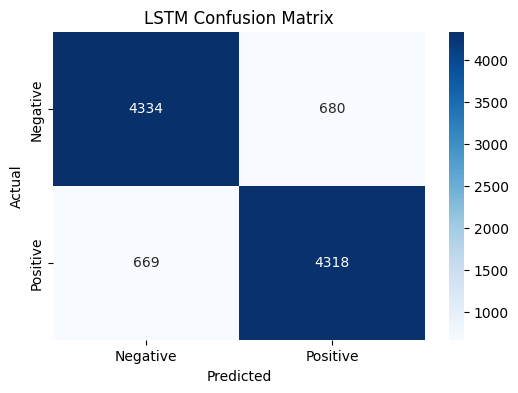

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()

### Plot Training History
Creates two subplots showing, Training and validation accuracy and loss over epochs to helps to visualize model learning progress

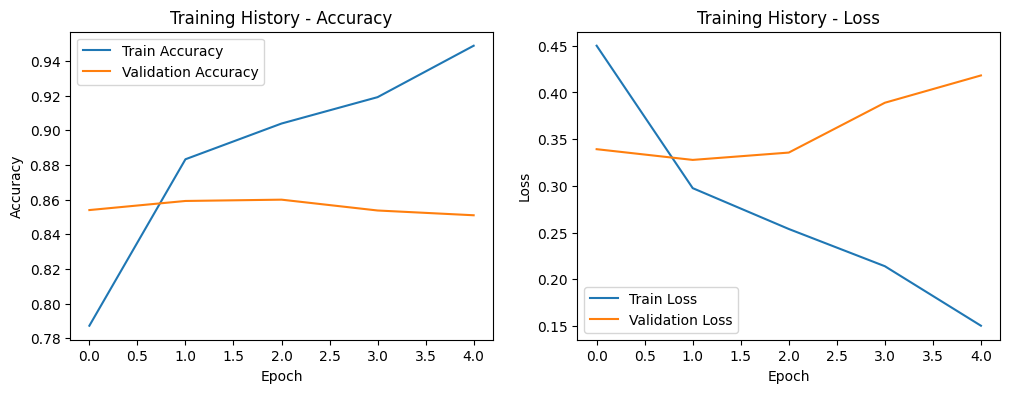

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Save the trained model and tokenizer for future use

For instance, [Real-world application](https://github.com/cs-joy/sentiment-app)

In [17]:
# Save model and tokenizer
model.save('output/lstm_sentiment_model.h5')
with open('output/lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Demo script for using the trained model and tokenizer

In [18]:
# Demo function for LSTM
def predict_sentiment_lstm(text):
    # load model and tokenizer
    from tensorflow.keras.models import load_model
    loaded_model = load_model('output/lstm_sentiment_model.h5')
    with open('output/lstm_tokenizer.pkl', 'rb') as f:
        loaded_tokenizer = pickle.load(f)

    # clean and prepare text
    cleaned_text = clean_text(text)
    seq = loaded_tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # predict
    proba = loaded_model.predict(padded)[0][0]
    sentiment = "Positive" if proba > 0.5 else "Negative"
    confidence = proba if proba > 0.5 else 1 - proba

    return f"{sentiment} (confidence: {confidence:.2f})"

In [19]:
# Example usage of the demo script `predict_sentiment()`
test_text = "This movie was absolutely fantastic, I loved every minute of it!"
print(f"Text: {test_text}")
print(f"Predicted Sentiment: {predict_sentiment_lstm(test_text)}")

test_text = "The film was terrible, with bad acting and a boring plot."
print(f"Text: {test_text}")
print(f"Predicted Sentiment: {predict_sentiment_lstm(test_text)}")

Text: This movie was absolutely fantastic, I loved every minute of it!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Predicted Sentiment: Positive (confidence: 0.88)
Text: The film was terrible, with bad acting and a boring plot.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Sentiment: Negative (confidence: 0.99)


### Conclusion
In this workflow for sentiment analysis using LSTM networks, achieving good performance (86.51% accuracy) on the IMDB review classification task. The model architecture includes modern techniques like bidirectional LSTMs, dropout for regularization, and learning rate scheduling.